# **QnA Classification**

## 데이터 탐색

### 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import scipy.stats as spst
from scipy.sparse import csr_matrix, hstack, save_npz

from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt, Kkma
from mecab import MeCab
from khaiii import KhaiiiApi
import nltk
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from nltk import FreqDist
from collections import Counter

import os
from PIL import Image
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

### 데이터 불러오기

In [2]:
path = "./train.csv"
law_data = pd.read_csv(path)
data = law_data.copy()

In [3]:
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


### 원본 데이터 확인

In [4]:
# 결측치 확인
data.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
# 라벨 유형 별 갯수 및 비율
print(data["label"].value_counts())
print("-"*30)
label_percent = (data["label"].value_counts() / data["label"].count() * 100).round(2)
print(label_percent)

label
코드2       1097
웹          732
이론         728
시스템 운영     561
코드1        488
원격         100
Name: count, dtype: int64
------------------------------
label
코드2       29.60
웹         19.75
이론        19.64
시스템 운영    15.14
코드1       13.17
원격         2.70
Name: count, dtype: float64


### 폰트 설정

In [3]:
FONT_PATH = '/usr/share/fonts/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
fm.fontManager.addfont(FONT_PATH)

print(font_name)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 텍스트 길이 확인

In [4]:
# 텍스트 길이 확인을 위한 컬럼 생성 및 값 부여
data["txt_len"] = data["text"].apply(len)

In [5]:
data.head()

,text,label,txt_len
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144


In [6]:
# 텍스트 길이 최대값, 최소값, 평균 확인
data["txt_len"].max(), data["txt_len"].min(), data["txt_len"].mean()

(6012, 9, 200.95736643281165)

In [7]:
# 텍스트 길이 상위, 하위 값의 내용 형태 확인
data[data["txt_len"] > 5000].head()

,text,label,txt_len
472,NoSuchElementException Trac...,웹,5489
834,C:\dev\mysite_std&gt; python .\manage.py make...,웹,5187
1255,$ python manage.py createsuperuser\n\nYou have...,웹,5690
1617,교수님이 치시는거 따라 쳤는데 계속 저 오류가 반복합니다.\n\n# 대여소별 이용건...,코드2,5454
2561,sns.kdeplot(x = td[var])\nplt.show()\n\n------...,코드2,6012


In [8]:
data[data["txt_len"] < 20].head()

,text,label,txt_len
66,가치제안을 위한 필요사항,이론,13
226,타임아웃이 왜 뜨는지 궁금합니다!,웹,18
334,원격제어를 추가하는 것이 안됩니다,원격,18
336,특강은 녹화본 올라올까요?,시스템 운영,14
381,제출은 어떤 걸 하나요?,시스템 운영,13


### 형태소 분석

In [9]:
# 분석기 불러오기
mecab = MeCab()
kkma = Kkma()
okt = Okt()
khaiii = KhaiiiApi()

In [10]:
# 분석기 함수 정의
def okt_analysis(x):
    return (okt.nouns(x), okt.morphs(x), okt.pos(x))

def kkma_analysis(x):
    return (kkma.nouns(x), kkma.morphs(x), kkma.pos(x))

def mecab_analysis(x):
    return (mecab.nouns(x), mecab.morphs(x), mecab.pos(x))

def khaiii_analysis(sentence):
    nouns, morphs, pos = [], [], []
    for word in khaiii.analyze(sentence):
        word_nouns = []
        word_morphs = []
        for morph in word.morphs:
            if morph.tag.startswith('N') and morph.tag != "NNBC":
                word_nouns.append(morph.lex)
            word_morphs.append((morph.lex, morph.tag))
        morphs.append(word_morphs)
        pos.extend(word_morphs)
        nouns.extend(word_nouns)
    return (nouns, morphs, pos)

In [11]:
okt_df = data.copy()
okt_df[['nouns', 'morphs', 'pos']] = okt_df['text'].apply(lambda x: pd.Series(okt_analysis(x)))

kkma_df = data.copy()
kkma_df[['nouns', 'morphs', 'pos']] = kkma_df['text'].apply(lambda x: pd.Series(kkma_analysis(x)))

mecab_df = data.copy()
mecab_df[['nouns', 'morphs', 'pos']] = mecab_df['text'].apply(lambda x: pd.Series(mecab_analysis(x)))

khaiii_df = data.copy()
khaiii_df[['nouns', 'morphs', 'pos']] = khaiii_df['text'].apply(lambda x: pd.Series(khaiii_analysis(x)))

In [18]:
# 확인
okt_df.head()

,text,label,txt_len,nouns,morphs,pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 이, 가정, 그냥, 선언, 것]","[self, ., convs, 1, =, nn, ., ModuleList, ([, ...","[(self, Alpha), (., Punctuation), (convs, Alph..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[현재, 이미지, 개, 업로드, 위해, 자바스크립트, 적, 폼, 개, 생, 클릭, ...","[현재, 이미지, 를, 여러, 개, 업로드, 하기, 위해, 자바스크립트, 로, 동,...","[(현재, Noun), (이미지, Noun), (를, Josa), (여러, Modi..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[를, 사용, 때, 질문, 포함, 제대로, 작동, 것, 질문, 제공, 파일, 폴더,...","[glob, ., glob, (, PATH, ), 를, 사용, 할, 때, 질문, 입...","[(glob, Alpha), (., Punctuation), (glob, Alpha..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[tmpp, =, tmp, ., groupby, (, by, =, ', Addr, ...","[(tmpp, Alpha), (=, Punctuation), (tmp, Alpha)..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 는걸, 이해, 실행, 폴더, 이미지, 저장, 질문]","[filename, =, TEST, _, IMAGE, +, str, (, round...","[(filename, Alpha), (=, Punctuation), (TEST, A..."


In [19]:
# 확인
kkma_df.head()

,text,label,txt_len,nouns,morphs,pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[1, 2, 100, 여기, 사이즈, 은, 단어, 최대, 길이, 가정, 선언]","[self, ., convs, 1, =, nn, ., ModuleList, (, [...","[(self, OL), (., SF), (convs, OL), (1, NR), (=..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[현재, 이미지, 개, 업, 업로드, 로드, 자바, 자바스크립트, 스크립트, 동적,...","[현재, 이미지, 를, 여러, 개, 업, 로드, 하, 기, 위하, 어, 자바, 스크...","[(현재, NNG), (이미지, NNG), (를, JKO), (여러, MDT), (..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 공해, 공해주신, 주신, 파일, 3, 폴더, 안...","[glob, ., glob, (, PATH, ), 를, 사용, 하, ㄹ, 때, 질문...","[(glob, OL), (., SF), (glob, OL), ((, SS), (PA..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[1, 15, 5, 1000, 오, 오류, 류, 해결]","[tmpp, =, tmp, ., groupby, (, by, =, ', Addr, ...","[(tmpp, OL), (=, SW), (tmp, OL), (., SF), (gro..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 이미지, 저장, 이해, 실행, 질문]","[filename, =, TEST, _, IMAGE, +, str, (, round...","[(filename, OL), (=, SW), (TEST, OL), (_, SW),..."


In [20]:
# 확인
mecab_df.head()

,text,label,txt_len,nouns,morphs,pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널, 사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[self, ., convs, 1, =, nn, ., ModuleList, (, [...","[(self, SL), (., SY), (convs, SL), (1, SN), (=..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바, 스크립트, 동적, 폼, 개, 생성, 데, 클릭, 뭘...","[현재, 이미지, 를, 여러, 개, 업로드, 하, 기, 위해, 자바, 스크립트, 로...","[(현재, MAG), (이미지, NNG), (를, JKO), (여러, MM), (개..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 폴더,...","[glob, ., glob, (, PATH, ), 를, 사용, 할, 때, 질문, 입...","[(glob, SL), (., SY), (glob, SL), ((, SSO), (P..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[tmpp, =, tmp, ., groupby, (, by, =, ', Addr, ...","[(tmpp, SL), (=, SY), (tmp, SL), (., SY), (gro..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 걸로, 이해, 실행, 폴더, 이미지, 저장, 질문]","[filename, =, TEST, _, IMAGE, +, str, (, round...","[(filename, SL), (=, SY), (TEST, SL), (_, SY),..."


In [21]:
# 확인
khaiii_df.head()

,text,label,txt_len,nouns,morphs,pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[[(self, SL), (., SP), (convs, SL), (1, SN)], ...","[(self, SL), (., SP), (convs, SL), (1, SN), (=..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바스크립트, 동적, 폼, 개, 생성, 클릭, 생성, 뭐,...","[[(현재, MAG)], [(이미지, NNG), (를, JKO)], [(여러, MM...","[(현재, MAG), (이미지, NNG), (를, JKO), (여러, MM), (개..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 안, ...","[[(glob, SL), (., SF), (glob, SL), ((, SS), (P...","[(glob, SL), (., SF), (glob, SL), ((, SS), (PA..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[[(tmpp, SL)], [(=, SW)], [(tmp, SL), (., SP),...","[(tmpp, SL), (=, SW), (tmp, SL), (., SP), (gro..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 것, 이해, 실행, 폴더, 이미지, 저장, 질문]","[[(filename, SL)], [(=, SW)], [(TEST, SL), (_,...","[(filename, SL), (=, SW), (TEST, SL), (_, SS),..."


In [12]:
# khaiii 채택
results_df = data.copy()
results_df[['nouns', 'morphs', 'pos']] = khaiii_df[['nouns', 'morphs', 'pos']]

### 불용어 처리

In [13]:
# 불용어 사전을 이용하여 불용어 불러오기
with open("./Stopwords_ko.txt", "r", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

In [27]:
results_df.head()

,text,label,txt_len,nouns,morphs,pos
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[[(self, SL), (., SP), (convs, SL), (1, SN)], ...","[(self, SL), (., SP), (convs, SL), (1, SN), (=..."
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바스크립트, 동적, 폼, 개, 생성, 클릭, 생성, 뭐,...","[[(현재, MAG)], [(이미지, NNG), (를, JKO)], [(여러, MM...","[(현재, MAG), (이미지, NNG), (를, JKO), (여러, MM), (개..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 안, ...","[[(glob, SL), (., SF), (glob, SL), ((, SS), (P...","[(glob, SL), (., SF), (glob, SL), ((, SS), (PA..."
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[[(tmpp, SL)], [(=, SW)], [(tmp, SL), (., SP),...","[(tmpp, SL), (=, SW), (tmp, SL), (., SP), (gro..."
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 것, 이해, 실행, 폴더, 이미지, 저장, 질문]","[[(filename, SL)], [(=, SW)], [(TEST, SL), (_,...","[(filename, SL), (=, SW), (TEST, SL), (_, SS),..."


In [14]:
# 불용어 처리
results_df["nouns_no_sw"] = results_df["nouns"].apply(lambda x: [word for word in x if word not in stopwords])

In [29]:
results_df.head()

,text,label,txt_len,nouns,morphs,pos,nouns_no_sw
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[[(self, SL), (., SP), (convs, SL), (1, SN)], ...","[(self, SL), (., SP), (convs, SL), (1, SN), (=...","[커널사이즈, 단어, 최대, 길이, 가정, 선언]"
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바스크립트, 동적, 폼, 개, 생성, 클릭, 생성, 뭐,...","[[(현재, MAG)], [(이미지, NNG), (를, JKO)], [(여러, MM...","[(현재, MAG), (이미지, NNG), (를, JKO), (여러, MM), (개...","[이미지, 업로드, 자바스크립트, 동적, 폼, 생성, 클릭, 생성, 기본, 예제, ..."
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 안, ...","[[(glob, SL), (., SF), (glob, SL), ((, SS), (P...","[(glob, SL), (., SF), (glob, SL), ((, SS), (PA...","[사용, 질문, 포함, 작동, 질문, 제공, 파일, 폴더, 포함, 정상, 작동]"
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[[(tmpp, SL)], [(=, SW)], [(tmp, SL), (., SP),...","[(tmpp, SL), (=, SW), (tmp, SL), (., SP), (gro...","[오류, 해결]"
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 것, 이해, 실행, 폴더, 이미지, 저장, 질문]","[[(filename, SL)], [(=, SW)], [(TEST, SL), (_,...","[(filename, SL), (=, SW), (TEST, SL), (_, SS),...","[폴더, 이미지, 저장, 이해, 실행, 폴더, 이미지, 저장, 질문]"


### 단어, 알파벳, 특수문자 빈도수 확인

In [15]:
# 전체 데이터에서 각 단어가 나온 빈도수 확인
word_cnt = Counter(word for word_list in results_df['nouns'] for word in word_list)

In [31]:
print(word_cnt)

Counter({'것': 2108, '수': 947, '값': 732, '문제': 693, '때': 690, '데이터': 617, '코드': 612, '번': 599, '실습': 590, '파일': 557, '안녕': 530, '감사': 520, '오류': 502, '부분': 482, '질문': 465, '경우': 461, '확인': 434, '진행': 433, '사용': 428, '입력': 402, '개': 349, '이해': 345, '실행': 344, '중': 344, '제': 335, '출력': 329, '제출': 327, '문': 323, '모델': 323, '방법': 310, '변수': 299, '결과': 277, '작성': 257, '해결': 253, '시간': 252, '후': 248, '해당': 243, 'ㅠ': 224, '추가': 223, '발생': 222, '거': 219, '시': 217, '강사': 217, '위': 212, '첨부': 201, '에러': 200, '이유': 196, '함수': 195, 'ㅠㅠ': 193, '내용': 188, '가능': 186, '이': 183, '생각': 183, '관련': 181, '부탁': 180, '무엇': 179, '설정': 179, '설명': 178, '다음': 177, '일': 177, '학습': 175, '드': 173, '생성': 172, '의미': 172, '아래': 171, '과정': 171, '분석': 170, '저': 156, '답변': 155, '사진': 152, '저장': 151, '차이': 150, '열': 149, '뭐': 143, '예측': 141, '이미지': 136, '어디': 134, '하나': 133, '점': 130, '분': 127, '여기': 124, '수정': 124, '기준': 122, '이용': 120, '제거': 119, '오늘': 118, '변경': 117, '연결': 113, '지정': 112, '식': 110, '전처리': 109, '처리': 108

In [16]:
# 질문별 알파벳, 특수문자 빈도수 확인 및 데이터 프레임 저장
results_df["alpha_cnt"] = results_df["text"].apply(lambda x: len([char for char in x if char.lower() in string.ascii_lowercase]))
results_df["punc_cnt"] = results_df["text"].apply(lambda x: len([char for char in x if char in string.punctuation]))

In [33]:
results_df.head()

,text,label,txt_len,nouns,morphs,pos,nouns_no_sw,alpha_cnt,punc_cnt
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[[(self, SL), (., SP), (convs, SL), (1, SN)], ...","[(self, SL), (., SP), (convs, SL), (1, SN), (=...","[커널사이즈, 단어, 최대, 길이, 가정, 선언]",40,18
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹,119,"[이미지, 개, 업로드, 자바스크립트, 동적, 폼, 개, 생성, 클릭, 생성, 뭐,...","[[(현재, MAG)], [(이미지, NNG), (를, JKO)], [(여러, MM...","[(현재, MAG), (이미지, NNG), (를, JKO), (여러, MM), (개...","[이미지, 업로드, 자바스크립트, 동적, 폼, 생성, 클릭, 생성, 기본, 예제, ...",0,6
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2,147,"[사용, 때, 질문, 포함, 작동, 것, 질문, 제공, 파일, 폴더, 포함, 안, ...","[[(glob, SL), (., SF), (glob, SL), ((, SS), (P...","[(glob, SL), (., SF), (glob, SL), ((, SS), (PA...","[사용, 질문, 포함, 작동, 질문, 제공, 파일, 폴더, 포함, 정상, 작동]",31,12
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2,279,"[오류, 해결]","[[(tmpp, SL)], [(=, SW)], [(tmp, SL), (., SP),...","[(tmpp, SL), (=, SW), (tmp, SL), (., SP), (gro...","[오류, 해결]",160,67
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2,144,"[안, 폴더, 안, 이미지, 저장, 것, 이해, 실행, 폴더, 이미지, 저장, 질문]","[[(filename, SL)], [(=, SW)], [(TEST, SL), (_,...","[(filename, SL), (=, SW), (TEST, SL), (_, SS),...","[폴더, 이미지, 저장, 이해, 실행, 폴더, 이미지, 저장, 질문]",53,13


### 데이터 시각화

PearsonRResult(statistic=0.8720874347974618, pvalue=0.0)

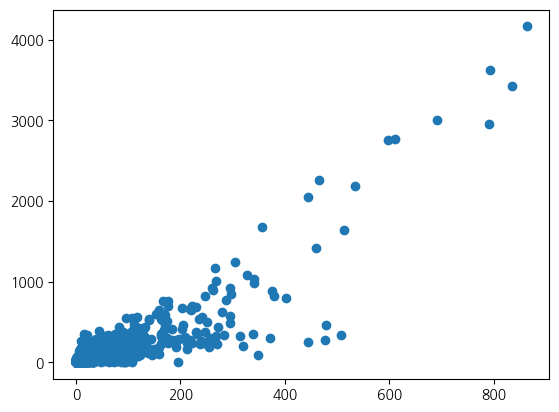

In [34]:
plt.scatter(results_df["punc_cnt"], results_df["alpha_cnt"])
spst.pearsonr(results_df["punc_cnt"], results_df["alpha_cnt"])

상관계수 0.8720, p-value 0.0으로 특수문자 갯수와 알파벳 갯수는 강한 양의 상관 관계를 나타낸다.

시각적으로 보아도 선이 그려진다

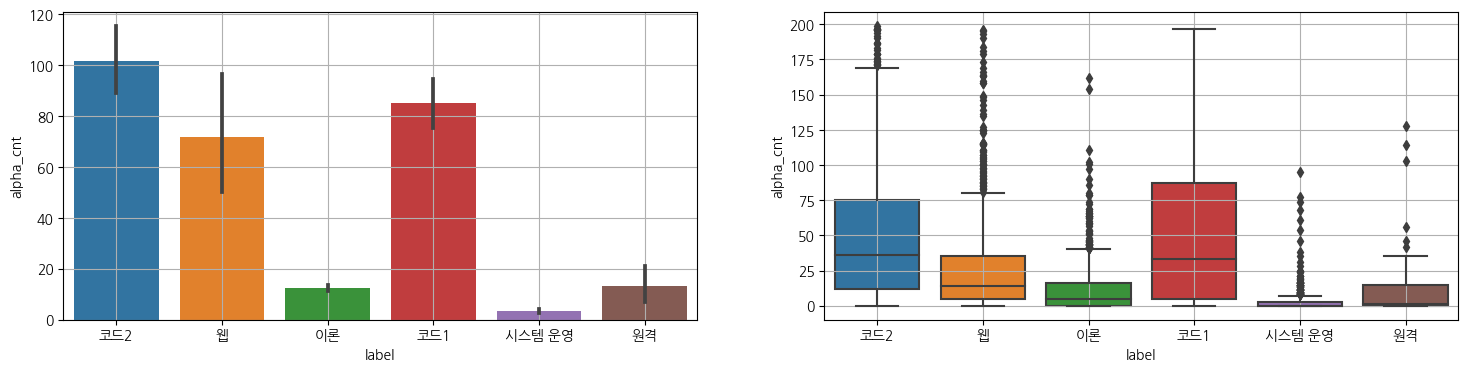

In [35]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.barplot(x="label", y="alpha_cnt", data=results_df)
plt.grid()

plt.subplot(1,2,2)
sns.boxplot(x= "label", y="alpha_cnt", data=results_df[results_df["alpha_cnt"] < 200])
plt.grid()
plt.show()

질문 유형이 코드1, 코드2, 웹의 경우 알파벳 갯수가 월등히 많은 것을 확인

알파벳 갯수가 질문 유형 분류에 큰 도움이 될 것으로 예상

### nltk로 텍스트 분석

In [17]:
results_df.head(1)

,text,label,txt_len,nouns,morphs,pos,nouns_no_sw,alpha_cnt,punc_cnt
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2,144,"[여기, 커널사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[[(self, SL), (., SP), (convs, SL), (1, SN)], ...","[(self, SL), (., SP), (convs, SL), (1, SN), (=...","[커널사이즈, 단어, 최대, 길이, 가정, 선언]",40,18


In [18]:
# nouns 열 리스트화
nouns_list = [nouns for sublist in results_df["nouns"] for nouns in sublist]

# nouns_no_sw 열 리스트화
nouns_no_sw_list = [nouns for sublist in results_df["nouns_no_sw"] for nouns in sublist]

In [19]:
# nltk Text로 변경
nouns_text = nltk.Text(nouns_list)
nouns_no_sw_text = nltk.Text(nouns_no_sw_list)

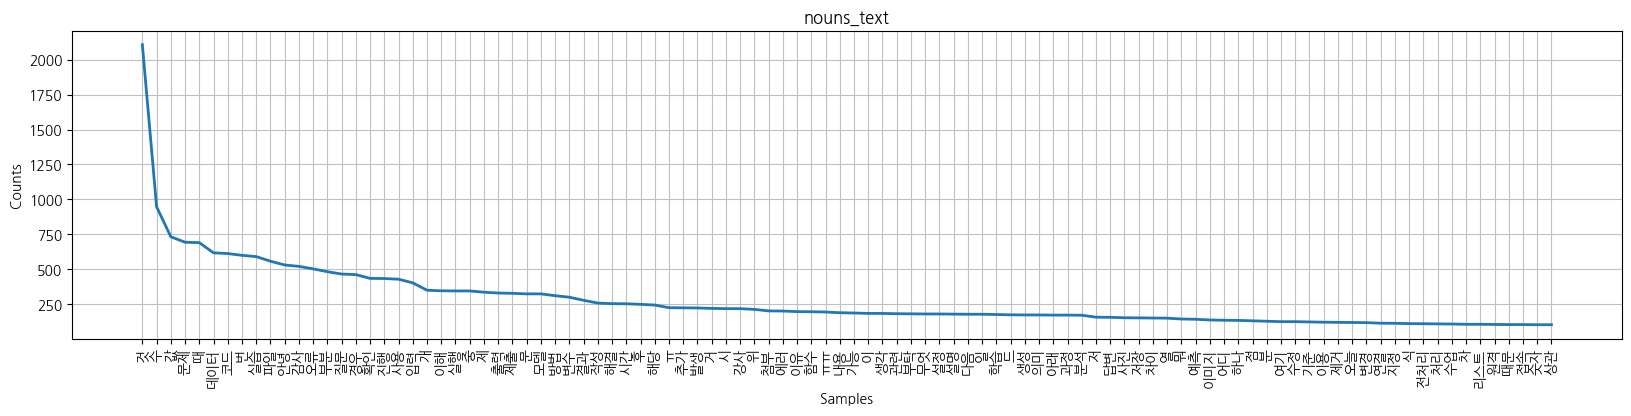

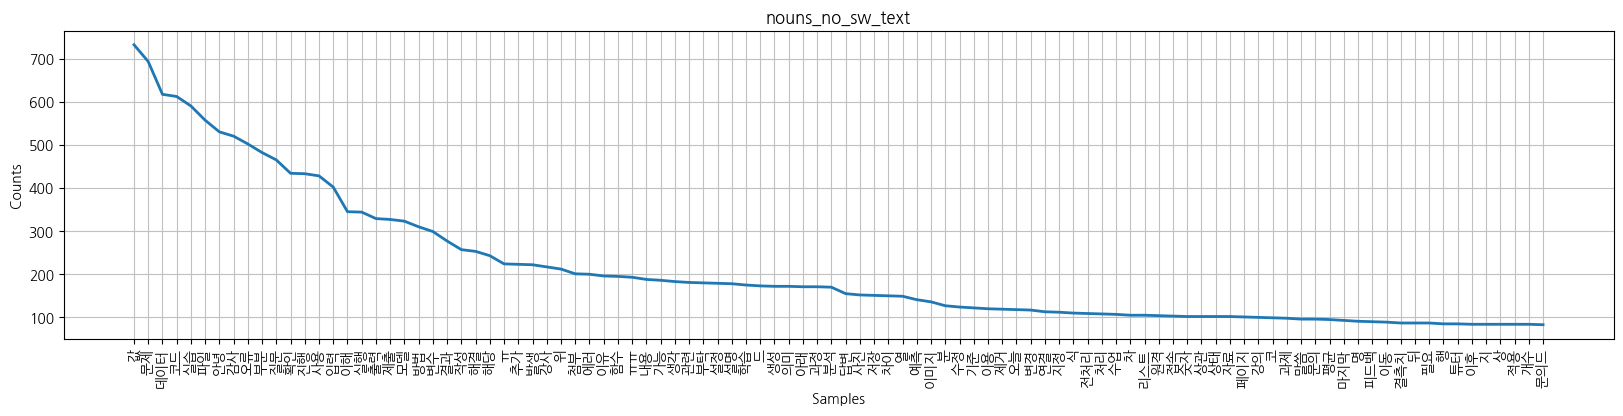

In [50]:
plt.figure(figsize=(20,4))
plt.title('nouns_text')
nouns_text.plot(100)

plt.figure(figsize=(20,4))
plt.title('nouns_no_sw_text')
nouns_no_sw_text.plot(100)
plt.show()

불용어 처리하지 않은 데이터에서는 불용어가 압도적으로 많아 분석에 문제가 생길 것으로 판단

### Wordcloud

In [20]:
# Wordcloud 형태 정의
mask = np.array(Image.open('./comment.png'))
wc1 = WordCloud(font_path=FONT_PATH, background_color='white', max_font_size=500, mask=mask)
wc2 = WordCloud(font_path=FONT_PATH, background_color='white', max_font_size=500, mask=mask)

In [21]:
nouns_count = Counter(nouns_list)
nouns_no_sw_count = Counter(nouns_no_sw_list)

In [22]:
nouns_cloud = wc1.generate_from_frequencies(dict(nouns_count))
nouns_no_sw_cloud = wc2.generate_from_frequencies(dict(nouns_no_sw_count))

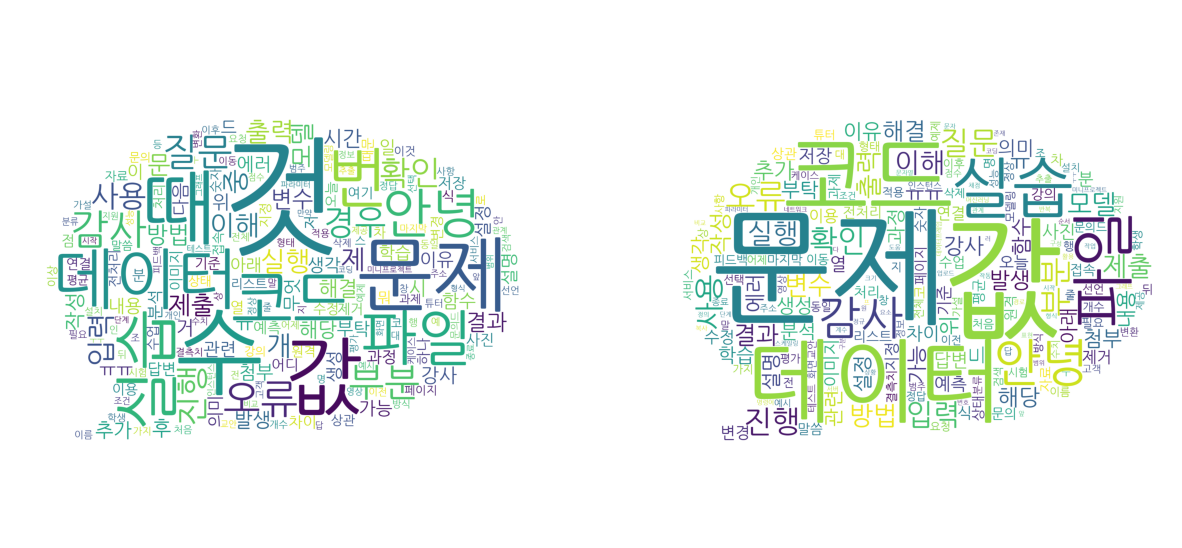

In [23]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(nouns_cloud)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(nouns_no_sw_cloud)
plt.show()

위와 마찬가지로 불용어 처리의 경우 분석이 용이해보인다.

### 벡터화

In [24]:
# 라벨 변경(코드1과 코드2는 코드에 관한 문의이기에 통일)
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}
preprocess_df = results_df.replace({"label": label_dict}).copy()

In [68]:
preprocess_df.head(1)

,text,label,txt_len,nouns,morphs,pos,nouns_no_sw,alpha_cnt,punc_cnt
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0,144,"[여기, 커널사이즈, 은, 단어, 최대, 길이, 가정, 선언, 것]","[[(self, SL), (., SP), (convs, SL), (1, SN)], ...","[(self, SL), (., SP), (convs, SL), (1, SN), (=...","[커널사이즈, 단어, 최대, 길이, 가정, 선언]",40,18


In [25]:
# df1_x : 불용어 처리하지 않은 데이터셋
# df2_x : 불용어 처리 완료한 데이터셋
df1_x = preprocess_df.drop(["label", "nouns_no_sw"], axis=1)
df2_x = preprocess_df.drop(["label", "nouns"], axis=1)
y = preprocess_df["label"]

In [26]:
df1_x_train, df1_x_val, y_train, y_val = train_test_split(df1_x, y, test_size=0.2, random_state=42)
df2_x_train, df2_x_val, y_train, y_val = train_test_split(df2_x, y, test_size=0.2, random_state=42)

In [27]:
# 벡터화 선언
cnt_vec = CountVectorizer()
bigram_vec = CountVectorizer(ngram_range=(2,2), min_df=2)
ngram_vec = CountVectorizer(ngram_range=(1,3))
tfidf_vec = TfidfVectorizer()

In [28]:
# 벡터화 진행
df1_x_train_nouns = [' '.join(text) for text in df1_x_train['nouns']]
df1_x_val_nouns = [' '.join(text) for text in df1_x_val['nouns']]

df1_cnt_x_train = cnt_vec.fit_transform(df1_x_train_nouns)
df1_bigram_x_train = bigram_vec.fit_transform(df1_x_train_nouns)
df1_ngram_x_train = ngram_vec.fit_transform(df1_x_train_nouns)
df1_tfidf_x_train = tfidf_vec.fit_transform(df1_x_train_nouns)

df1_cnt_x_val = cnt_vec.transform(df1_x_val_nouns)
df1_bigram_x_val = bigram_vec.transform(df1_x_val_nouns)
df1_ngram_x_val = ngram_vec.transform(df1_x_val_nouns)
df1_tfidf_x_val = tfidf_vec.transform(df1_x_val_nouns)



df2_x_train_nouns = [' '.join(text) for text in df2_x_train['nouns_no_sw']]
df2_x_val_nouns = [' '.join(text) for text in df2_x_val['nouns_no_sw']]

df2_cnt_x_train = cnt_vec.fit_transform(df2_x_train_nouns)
df2_bigram_x_train = bigram_vec.fit_transform(df2_x_train_nouns)
df2_ngram_x_train = ngram_vec.fit_transform(df2_x_train_nouns)
df2_tfidf_x_train = tfidf_vec.fit_transform(df2_x_train_nouns)

df2_cnt_x_val = cnt_vec.transform(df2_x_val_nouns)
df2_bigram_x_val = bigram_vec.transform(df2_x_val_nouns)
df2_ngram_x_val = ngram_vec.transform(df2_x_val_nouns)
df2_tfidf_x_val = tfidf_vec.transform(df2_x_val_nouns)

In [85]:
# 나머지 숫자형 변수들을 희소 행렬로 변환
df1_x_train_sparse = pd.DataFrame(df1_x_train, columns=['txt_len', 'alpha_cnt', 'punc_cnt']).values
df1_x_train_sparse = csr_matrix(df1_x_train_sparse)
df1_x_val_sparse = pd.DataFrame(df1_x_val, columns=['txt_len', 'alpha_cnt', 'punc_cnt']).values
df1_x_val_sparse = csr_matrix(df1_x_val_sparse)


df2_x_train_sparse = pd.DataFrame(df2_x_train, columns=['txt_len', 'alpha_cnt', 'punc_cnt']).values
df2_x_train_sparse = csr_matrix(df2_x_train_sparse)
df2_x_val_sparse = pd.DataFrame(df2_x_val, columns=['txt_len', 'alpha_cnt', 'punc_cnt']).values
df2_x_val_sparse = csr_matrix(df2_x_val_sparse)

In [87]:
# 최종 학습 데이터 구성
df1_cnt_x_train_final = hstack([df1_cnt_x_train, df1_x_train_sparse])
df1_bigram_x_train_final = hstack([df1_bigram_x_train, df1_x_train_sparse])
df1_ngram_x_train_final = hstack([df1_ngram_x_train, df1_x_train_sparse])
df1_tfidf_x_train_final = hstack([df1_tfidf_x_train, df1_x_train_sparse])

df1_cnt_x_val_final = hstack([df1_cnt_x_val, df1_x_val_sparse])
df1_bigram_x_val_final = hstack([df1_bigram_x_val, df1_x_val_sparse])
df1_ngram_x_val_final = hstack([df1_ngram_x_val, df1_x_val_sparse])
df1_tfidf_x_val_final = hstack([df1_tfidf_x_val, df1_x_val_sparse])



df2_cnt_x_train_final = hstack([df2_cnt_x_train, df2_x_train_sparse])
df2_bigram_x_train_final = hstack([df2_bigram_x_train, df2_x_train_sparse])
df2_ngram_x_train_final = hstack([df2_ngram_x_train, df2_x_train_sparse])
df2_tfidf_x_train_final = hstack([df2_tfidf_x_train, df2_x_train_sparse])

df2_cnt_x_val_final = hstack([df2_cnt_x_val, df2_x_val_sparse])
df2_bigram_x_val_final = hstack([df2_bigram_x_val, df2_x_val_sparse])
df2_ngram_x_val_final = hstack([df2_ngram_x_val, df2_x_val_sparse])
df2_tfidf_x_val_final = hstack([df2_tfidf_x_val, df2_x_val_sparse])

In [89]:
# 데이터 저장
save_npz('df1_cnt_x_train.npz', df1_cnt_x_train_final)
save_npz('df1_bigram_x_train.npz', df1_bigram_x_train_final)
save_npz('df1_ngram_x_train.npz', df1_ngram_x_train_final)
save_npz('df1_tfidf_x_train.npz', df1_tfidf_x_train_final)

save_npz('df1_cnt_x_val.npz', df1_cnt_x_val_final)
save_npz('df1_bigram_x_val.npz', df1_bigram_x_val_final)
save_npz('df1_ngram_x_val.npz', df1_ngram_x_val_final)
save_npz('df1_tfidf_x_val.npz', df1_tfidf_x_val_final)



save_npz('df2_cnt_x_train.npz', df2_cnt_x_train_final)
save_npz('df2_bigram_x_train.npz', df2_bigram_x_train_final)
save_npz('df2_ngram_x_train.npz', df2_ngram_x_train_final)
save_npz('df2_tfidf_x_train.npz', df2_tfidf_x_train_final)

save_npz('df2_cnt_x_val.npz', df2_cnt_x_val_final)
save_npz('df2_bigram_x_val.npz', df2_bigram_x_val_final)
save_npz('df2_ngram_x_val.npz', df2_ngram_x_val_final)
save_npz('df2_tfidf_x_val.npz', df2_tfidf_x_val_final)



y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)